In [1]:
# multistep(7days) ahead forecasting
# 추석연휴 피쳐 변경 & 범주형 데이터는 스케일링 제외 2022.05.25

In [2]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error

# Keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

In [3]:
### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred) # 아래 evaluation_trte를 보면 실제Y값(Y_real)을 데이터프레임으로 입력받았기 때문에 다시 array로 변환하고 flatten함, 예측Y값(Y_pred)은 array를 flatten한 값으로 입력받기때문에 추가변환 없음     
    if loss_length != 0:                                     # 잔차값 array길이가 0이 아니면 실제Y값을 길이를 줄여준다. 하지만 왜 앞에서부터 짜르지?
        Y_real = Y_real[loss_length:]                        
    if graph_on == True:                                     
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6), # 실제Y값(Y_real)은 flattenee된 array이니까 다시 데이터프레임으로 변환하고 실제값(Y_real)의 index과 동일하게 indexing하고 concat한다.
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)

In [4]:
# Data Loading
cvd19   = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/0513/cvd19_ox_0513.csv')   # 코로나
wth     = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/0513/wth_0513.csv')     # 기상 & 관광입도객(제주관광협회)
psg     = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv//0513/psg_0513.csv')     # 공합입도객수
sch     = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/0513/search_0513.csv')     # 검색량

#rnt     = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/rnt.csv')     # 렌트카
#cpt_prc = pd.read_csv('/Users/kimjinseok/Desktop/kaflix_demand forecasting/csv/cpt_prc.csv') # 경쟁사 가격
#mk_sr   = pd.read_csv('/Users/kimjinseok/Desktop/kaflix_demand forecasting/csv/mk_sr.csv')   # 시장점유율
#air_tck = pd.read_csv('/Users/kimjinseok/Desktop/kaflix_demand forecasting/csv/air_tck.csv') # 예매 가능한 비행티켓(인터파크)
#prm     = pd.read_csv('/Users/kimjinseok/Desktop/kaflix_demand forecasting/csv/prm.csv')     # 프로모션

# Datetime 
cvd19['date']=pd.to_datetime(cvd19['date'])
wth['DT']=pd.to_datetime(wth['DT'])
psg['DT']=pd.to_datetime(psg['DT'])
sch['period']=pd.to_datetime(sch['period'])
cvd19=cvd19[cvd19['location']=='South Korea']

# psg   : 2019-05-01 ~ 2022-04-28 제주공항 입도객수
# cvd19 : 2020-01-22 ~ 2022-05-12 코로나 거리두기 정책지수
# sch   : 2019-05-14 ~ 2022-05-13 '제주렌트카' 검색량
# wth   : 2017-01-01 ~ 2022-12-25 날씨 및 공휴일
# 모두 겹치는 일정 2019-05-14(코로나 제외) ~ 2022-04-28

# psg에 모든 주에 데이터 있는지 검증 => 20190-05-01부터 2022-04-28까지는 1094일
#len(psg['DT'].unique()) 

# Indexing pgs date & left join with other data
psg = psg.sort_values("DT")
psg.set_index("DT", inplace=True)
psg = psg.loc[psg.index >= '2019-05-14',:]  # 0513까지 삭제
psg = psg.groupby("DT")['ARRIVE_PPL'].sum() # 일별 입도객 합계
psg = pd.DataFrame(psg)                     # 데이터프레임만들고
cvd19.rename(columns={'date':'DT'}, inplace=True)
sch.rename(columns={'period':'DT'}, inplace=True)

# Select Required Data
cvd19 = cvd19[['DT', 'stringency_index', 'new_tests_per_thousand', 'total_vaccinations_per_hundred', 'total_boosters_per_hundred']] 
wth = wth[['DT','TEMPERTURE','RAIN','HOLIDAY_NAME']]

# merge psg & cvd19
merged = pd.merge(psg, cvd19, on="DT", how="left")

# holiday preprocessing for long and interspersed
wth_h = wth[['DT', 'HOLIDAY_NAME']]

# 1 for 'Lunar New Years' and 'Chuseok' & other holidays 
#wth_h['wth_m']=np.where((wth_h['HOLIDAY_NAME']=='설날') | (wth_h['HOLIDAY_NAME']=='추석'), 1, 0)
wth_h.HOLIDAY_NAME.loc[~wth_h.HOLIDAY_NAME.isnull()] = 1
wth_h = wth_h.sort_values('DT')
wth_h.HOLIDAY_NAME.loc[wth_h.HOLIDAY_NAME.isnull()] = 0
#wth_h['HOLIDAY_NAME']=wth_h['HOLIDAY_NAME'] + wth_h['wth_m']
wth_h.HOLIDAY_NAME.unique()

array([1, 0], dtype=object)

In [5]:
# [long holidays] and [Holidays Interspersed with Workdays]
wth_h['dayofweek'] = wth_h.DT.dt.dayofweek

# 공휴일인데 금요일(4)이면 그주 금요일(4)을 연휴시작으로
# 공휴일인데 월요일(0)이면 전주 토요일(5)을 연휴시작으로
wth_h['flong']=np.where((wth_h['HOLIDAY_NAME'] == 1) & (wth_h['dayofweek'] == 4), 1, 0)
wth_h['mlong']=np.where((wth_h['HOLIDAY_NAME'] == 1) & (wth_h['dayofweek'] == 0), 1, 0)

#월요일 연휴는 그 전 토요일에 연휴 시작 표시
wth_h['mlong']= wth_h['mlong'].shift(-2)
wth_h['mlong'].fillna(method='ffill', inplace = True)

#금요일 연휴, 월요일 연휴 컬럼 합치기
wth_h['long_h']=wth_h['flong'] + wth_h['mlong'] 

#연휴시작 하루 전날 표시
wth_h['b_long_h']=wth_h['long_h'].shift(-1)
wth_h['b_long_h'].fillna(method='ffill', inplace = True)

# 징검다리 로직
# 휴일인데 목요일(3)이면 그주 목요일(3)을 징검다리 연휴시작
# 휴일인데 화요일(1)이면 전주 토요일(5)을 징검다리 연휴시작
wth_h['thinter'] = np.where((wth_h['HOLIDAY_NAME'] == 1) & (wth_h['dayofweek'] == 3), 1, 0)
wth_h['tuinter'] = np.where((wth_h['HOLIDAY_NAME'] == 1) & (wth_h['dayofweek'] == 1), 1, 0)

# 화요일 징검다리는 전주 토요일에 연휴 시작 표시
wth_h['tuinter'] = wth_h['tuinter'].shift(-3)
wth_h['tuinter'].fillna(method='ffill', inplace = True)
wth_h['inter_h'] = wth_h['thinter'] + wth_h['tuinter'] 

# 징검다리 시작 하루 전날 표시
wth_h['b_inter_h'] = wth_h['inter_h'].shift(-1)
wth_h['b_inter_h'].fillna(method='ffill', inplace = True)


In [6]:
# [first day of myeojeol] 
#holiday    : 설날/추석 명절 -> 1
#first_m    : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (일) 또는 (월)이면 (토)가 시작일 -> 1 표시
#b_first_m  : 설날/추석 명절연휴 시작일 전날, 단 명절 연휴시작이 (일) 또는 (월)이면 (금)이 시작일 전날 -> 1로 표시b

In [7]:
#first_m    : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (일) 또는 (월)이면 (토)가 시작일 -> 1 표시
#2017-01-27, 2017-10-03, 2018-02-15, 2018-09-23, 2019-02-04, 2019-09-12, 2020-01-24, 2020-09-30, 2021-02-11, 2021-09-30, 2022-02-01

#first_m_nosm   : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (화) 또는 (수) 또는 (목) 또는 (금) 또는 (토) 이면 1
wth_h['first_m_nosm']=np.where(((wth_h['DT'] == '2017-01-27') |
                          (wth_h['DT'] == '2017-10-03') |
                          (wth_h['DT'] == '2018-02-15') |
                          (wth_h['DT'] == '2018-09-23') |
                          (wth_h['DT'] == '2019-02-04') |
                          (wth_h['DT'] == '2019-09-12') |
                          (wth_h['DT'] == '2020-01-24') |
                          (wth_h['DT'] == '2020-09-30') |
                          (wth_h['DT'] == '2021-02-11') |
                          (wth_h['DT'] == '2021-09-20') |
                          (wth_h['DT'] == '2022-01-31') )
                          & ((wth_h['dayofweek'] != 6) & (wth_h['dayofweek'] !=0)), 1,0)

#first_m_s   : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (일)이면 1로 표시하고 shift -1
wth_h['first_m_s']=np.where(((wth_h['DT'] == '2017-01-27') |
                          (wth_h['DT'] == '2017-10-03') |
                          (wth_h['DT'] == '2018-02-15') |
                          (wth_h['DT'] == '2018-09-23') |
                          (wth_h['DT'] == '2019-02-04') |
                          (wth_h['DT'] == '2019-09-12') |
                          (wth_h['DT'] == '2020-01-24') |
                          (wth_h['DT'] == '2020-09-30') |
                          (wth_h['DT'] == '2021-02-11') |
                          (wth_h['DT'] == '2021-09-20') |
                          (wth_h['DT'] == '2022-01-31') )
                          & (wth_h['dayofweek'] == 6), 1,0)
wth_h['first_m_s'] = wth_h['first_m_s'].shift(-1)
wth_h['first_m_s'].fillna(method='ffill', inplace = True)

#first_m_m   : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (월)이면 1로 표시하고 shift -2
wth_h['first_m_m']=np.where(((wth_h['DT'] == '2017-01-27') |
                          (wth_h['DT'] == '2017-10-03') |
                          (wth_h['DT'] == '2018-02-15') |
                          (wth_h['DT'] == '2018-09-23') |
                          (wth_h['DT'] == '2019-02-04') |
                          (wth_h['DT'] == '2019-09-12') |
                          (wth_h['DT'] == '2020-01-24') |
                          (wth_h['DT'] == '2020-09-30') |
                          (wth_h['DT'] == '2021-02-11') |
                          (wth_h['DT'] == '2021-09-20') |
                          (wth_h['DT'] == '2022-01-31') )
                          & (wth_h['dayofweek'] == 0), 1,0)
wth_h['first_m_m'] = wth_h['first_m_m'].shift(-2)
wth_h['first_m_m'].fillna(method='ffill', inplace = True)

wth_h['first_m'] = wth_h['first_m_nosm'] + wth_h['first_m_s'] + wth_h['first_m_m']

wth_h['b_first_m'] = wth_h['first_m'].shift(-1)
wth_h['b_first_m'].fillna(method='ffill', inplace=True)


In [8]:
wth_h.columns

Index(['DT', 'HOLIDAY_NAME', 'dayofweek', 'flong', 'mlong', 'long_h',
       'b_long_h', 'thinter', 'tuinter', 'inter_h', 'b_inter_h',
       'first_m_nosm', 'first_m_s', 'first_m_m', 'first_m', 'b_first_m'],
      dtype='object')

In [9]:
wth_h.drop(['flong', 'mlong', 'thinter','tuinter', 'first_m_nosm','first_m_s', 'first_m_m'], axis=1, inplace=True)

In [10]:
# merge wether & searching data 
wth=wth[['DT','TEMPERTURE','RAIN']]
wth=pd.merge(wth, wth_h, how='left', on='DT')
merged=pd.merge(merged, wth, on="DT", how="left")
merged=pd.merge(merged, sch, on='DT', how='left')
merged


# columns rename
merged.columns = ['datetime' , 'count', 'cvd_index', 'new_test', 'total_vaccin', 'total_booster' ,'temperature', 'rain', 'holiday', 'dayofweek','long_h','b_long_h','inter_h','b_inter_h','first_m','b_first_m','search']

# nan to zero
cvd_cols = ['cvd_index', 'new_test', 'total_vaccin', 'total_booster']
merged[cvd_cols] = merged[cvd_cols].replace({np.nan:0})

In [11]:
# feature engineering for time-series
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    # decompose trend / seasonal data 
    decompose=sm.tsa.seasonal_decompose(raw['count'], model='additive')
    decompose.plot()

    # add trend data 
    Y_trend=pd.DataFrame(decompose.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns=['count_trend']
    raw = pd.concat([raw, Y_trend], axis=1)
    
    # add seasonal data 
    Y_seasonal = pd.DataFrame(decompose.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns=['count_seasonal']
    raw = pd.concat([raw, Y_seasonal], axis=1)
    
    # add weekly data 
    Y_count_Week = raw[['count']].rolling(7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns=['count_Week']
    raw = pd.concat([raw, Y_count_Week], axis=1)
    
    # add difference data 
    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    raw = pd.concat([raw, Y_diff], axis=1)

    # add time series data 
    raw['year']       = raw.datetime.dt.year
    raw['quarter']    = raw.datetime.dt.quarter
    raw['month']      = raw.datetime.dt.month
    raw['count_lag1'] = raw['count']#.shift(1)
    #raw['count_lag1'].fillna(method = 'bfill', inplace=True)
    raw['count_lag2'] = raw['count']#.shift(2)
    #raw['count_lag2'].fillna(method = 'bfill', inplace=True)


    # dummy 변수(카테고리 변수) => holiday(0,1) / dayofweek(0,1,2,3,4,5,6) / long_h(0,1) / b_long_h(0,1) / inter_h(0,1) / b_inter_h(0,1) 
    #                         /first_m(0,1)/ b_first_m(0,1) / year(2019,2020,2021,2022) / month(1~12) / quarter(1~4)

    raw = pd.concat([raw, pd.get_dummies(raw['holiday'],   prefix='holiday'   + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['dayofweek'], prefix='dayofweek' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['long_h'],    prefix='long_h'    + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['b_long_h'],  prefix='b_long_h'  + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['inter_h'],   prefix='inter_h'   + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['b_inter_h'], prefix='b_inter_h' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['first_m'],   prefix='first_m'   + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['b_first_m'], prefix='b_first_m' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['year'],      prefix='year'      + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['month'],     prefix='month'     + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['quarter'],   prefix='quarter'   + '_dummy')], axis=1)

    raw = raw.drop(columns=['holiday', 'dayofweek', 'long_h', 'b_long_h', 'inter_h', 'b_inter_h','first_m','b_first_m', 'year', 'month', 'quarter'])
    
    raw_fe = raw.copy() 
    return raw_fe

# Reality _ feature_engineering_year_duplicated
# target = ['count_trend', 'count_seasonal', 'count_Week', 'count_diff']
def feature_engineering_year_duplicated(raw, target):
    raw_feRD = raw.copy()
    for col in target:
        raw_feRD.loc['2021-04-29':'2022-04-28', col] = raw_feRD.loc['2020-04-29':'2021-04-28', col].values
    return raw_feRD

# Data Split for time series to train & test
def datasplit_ts(raw, criteria):
    raw_train = raw.loc[merged.index < criteria, :]
    raw_test  = raw.loc[merged.index >= criteria, :]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    return raw_train, raw_test

# Y_colname = ['count']
# X_remove = ['datetime', 'DateTime']
# X_colname = [x for x in merged.columns if x not in Y_colname + X_remove]

# Data Split for Y_train, X_train
def datasplit_train(train, Y_colname, X_colname):
    X_colname = [x for x in train.columns if x not in Y_colname + X_remove]
    Y_train = train[Y_colname]
    X_train = train[X_colname]
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    return X_train, Y_train

# Data Split for Y_train, X_train
def datasplit_test(test, Y_colname, X_colname):
    X_colname = [x for x in test.columns if x not in Y_colname + X_remove]
    Y_test = test[Y_colname]
    X_test = test[X_colname]
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_test, Y_test


# modify lagged values of X_test
# target = ['count_lag1', 'count_lag2']
def feature_engineering_lag_modified(Y, X, target):
    X_lm = X.copy()
    i = 1
    for col in target:
        X_lm[col] = Y.shift(i).values
        X_lm[col].fillna(method='bfill', inplace=True)
        i = i + 1
    return X_lm

Train_size: (1021, 56) Test_size: (60, 56)
X_train: (1021, 54) Y_train: (1021, 1)
X_test: (60, 54) Y_test: (60, 1)


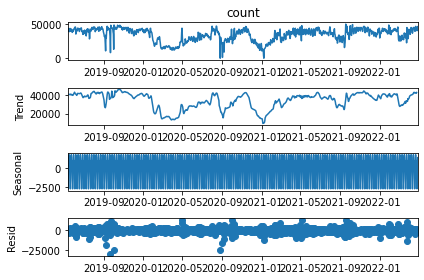

In [12]:
# Feature Engineering
merged_fe  = feature_engineering(merged)

# Reality _ feature_engineering_year_duplicated
target_d  = ['count_trend', 'count_seasonal', 'count_Week', 'count_diff']
merged_feRD = feature_engineering_year_duplicated(merged_fe, target_d)

# Data Split for time series to train & test
Train, Test = datasplit_ts(merged_feRD, '2022-02-28')

Y_colname = ['count']
X_remove = ['datetime', 'DateTime']
X_colname = [x for x in merged.columns if x not in Y_colname + X_remove]

# Data Split to X and Y
X_train, Y_train = datasplit_train(Train,Y_colname, X_colname)
X_test, Y_test = datasplit_test(Test,Y_colname, X_colname)

# Reality _ modify lagged values of X_train
target_l = ['count_lag1', 'count_lag2']
X_train = feature_engineering_lag_modified(Y_train, X_train, target_l)

# Reality _ modify lagged values of X_test
target_l = ['count_lag1', 'count_lag2']
X_test = feature_engineering_lag_modified(Y_test, X_test, target_l)


In [13]:
continous_feature=['cvd_index', 'new_test', 'total_vaccin', 'total_booster', 'temperature',
                   'rain', 'search', 'count_trend', 'count_seasonal', 'count_Week',
                   'count_diff', 'count_lag1', 'count_lag2']

In [14]:
category_feature=['holiday_dummy_0','holiday_dummy_1', 'dayofweek_dummy_0',
                  'dayofweek_dummy_1', 'dayofweek_dummy_2', 'dayofweek_dummy_3','dayofweek_dummy_4',
                  'dayofweek_dummy_5', 'dayofweek_dummy_6','long_h_dummy_0.0', 'long_h_dummy_1.0',
                  'b_long_h_dummy_0.0','b_long_h_dummy_1.0', 'inter_h_dummy_0.0', 'inter_h_dummy_1.0',
                  'b_inter_h_dummy_0.0', 'b_inter_h_dummy_1.0', 'first_m_dummy_0.0', 'first_m_dummy_1.0',
                  'b_first_m_dummy_0.0', 'b_first_m_dummy_1.0', 'year_dummy_2019', 'year_dummy_2020', 
                  'year_dummy_2021','year_dummy_2022', 'month_dummy_1', 'month_dummy_2', 'month_dummy_3',
                  'month_dummy_4', 'month_dummy_5', 'month_dummy_6', 'month_dummy_7','month_dummy_8',
                  'month_dummy_9', 'month_dummy_10', 'month_dummy_11','month_dummy_12', 'quarter_dummy_1', 
                  'quarter_dummy_2','quarter_dummy_3', 'quarter_dummy_4']

# LSTM

In [15]:
# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
batch_size = 32
n_steps_in = 24
n_steps_out = 7
epoch = 40
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_con = scaler_X_tr.fit_transform(X_train[continous_feature])
X_train_cat = X_train[category_feature].to_numpy()
X_train_lstm = np.concatenate((X_train_con, X_train_cat), axis=1)
Y_train_lstm = scaler_Y_tr.fit_transform(Y_train)

X_test_con = scaler_X_tr.transform(X_test[continous_feature])
X_test_cat = X_test[category_feature].to_numpy()
X_test_lstm = np.concatenate((X_test_con, X_test_cat), axis=1)
Y_test_lstm = scaler_Y_tr.transform(Y_test)

In [16]:
print('X_train_lstm:', X_train_lstm.shape, 'Y_train_lstm:', Y_train_lstm.shape)
print('X_test_lstm:', X_test_lstm.shape, 'Y_test_lstm:', Y_test_lstm.shape)

X_train_lstm: (1021, 54) Y_train_lstm: (1021, 1)
X_test_lstm: (60, 54) Y_test_lstm: (60, 1)


In [17]:
## X / Y Split
X_train_multi_lstm, Y_train_multi_lstm = [], []
for index in range(len(X_train_lstm)):
    # find the end of this pattern
    end_ix = index + n_steps_in
    out_end_ix = end_ix + n_steps_out - 1
    # check if we are beyond the dataset
    if out_end_ix > len(X_train_lstm):
        break
    #gather input and output parts of the pattern
    seq_x, seq_y = X_train_lstm[index:end_ix, :], Y_train_lstm[end_ix-1:out_end_ix, -1]
    X_train_multi_lstm.append(seq_x)
    Y_train_multi_lstm.append(seq_y)
X_train_multi_lstm, Y_train_multi_lstm = np.array(X_train_multi_lstm), np.array(Y_train_multi_lstm) 
print('X_train_multi_lstm:', X_train_multi_lstm.shape, 'Y_train_multi_lstm:', Y_train_multi_lstm.shape)


X_test_multi_lstm, Y_test_multi_lstm = [], []
for index in range(len(X_test_lstm)):
    # find the end of this pattern
    end_ix = index + n_steps_in
    out_end_ix = end_ix + n_steps_out - 1
    # check if we are beyond the dataset
    if out_end_ix > len(X_test_lstm):
        break
    #gather input and output parts of the pattern
    seq_x, seq_y = X_test_lstm[index:end_ix, :], Y_test_lstm[end_ix-1:out_end_ix, -1]
    X_test_multi_lstm.append(seq_x)
    Y_test_multi_lstm.append(seq_y)
X_test_multi_lstm, Y_test_multi_lstm = np.array(X_test_multi_lstm), np.array(Y_test_multi_lstm) 
print('X_test_multi_lstm:', X_test_multi_lstm.shape, 'Y_test_multi_lstm:', Y_test_multi_lstm.shape)

X_train_multi_lstm: (992, 24, 54) Y_train_multi_lstm: (992, 7)
X_test_multi_lstm: (31, 24, 54) Y_test_multi_lstm: (31, 7)


Metal device set to: Apple M1


2022-06-08 13:19:37.305397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-08 13:19:37.305515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           93696     
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 24, 256)           394240    
                                                                 
 dropout_1 (Dropout)         (None, 24, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 24, 128)           197120    
                                                                 
 dropout_2 (Dropout)         (None, 24, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                4

2022-06-08 13:19:38.254568: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-08 13:19:41.364259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 116s 4s/step - loss: 0.2419
Epoch 2/40
31/31 [==============================] - 112s 4s/step - loss: 0.0217
Epoch 3/40
31/31 [==============================] - 111s 4s/step - loss: 0.0108
Epoch 4/40
31/31 [==============================] - 112s 4s/step - loss: 0.0091
Epoch 5/40
31/31 [==============================] - 114s 4s/step - loss: 0.0086
Epoch 6/40
31/31 [==============================] - 113s 4s/step - loss: 0.0084
Epoch 7/40
31/31 [==============================] - 112s 4s/step - loss: 0.0082
Epoch 8/40
31/31 [==============================] - 114s 4s/step - loss: 0.0079
Epoch 9/40
31/31 [==============================] - 115s 4s/step - loss: 0.0077
Epoch 10/40
31/31 [==============================] - 113s 4s/step - loss: 0.0076
Epoch 11/40
31/31 [==============================] - 112s 4s/step - loss: 0.0076
Epoch 12/40
31/31 [==============================] - 113s 4s/step - loss: 0.0073
Epoch 13/40
31/31 [=============================

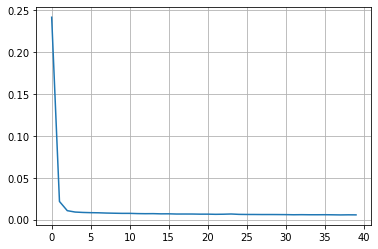

2022-06-08 14:35:43.797187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-08 14:35:59.450687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [18]:
# LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_multi_lstm.shape[1], X_train_multi_lstm.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit_multi_lstm = model.fit(X_train_multi_lstm, Y_train_multi_lstm, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit_multi_lstm.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred_multi_lstm = model.predict(X_train_multi_lstm)
Y_test_pred_multi_lstm = model.predict(X_test_multi_lstm)


In [19]:
print('X_train_multi_lstm:', X_train_multi_lstm.shape, 'Y_train_multi_lstm:', Y_train_multi_lstm.shape, 'Y_train_pred_multi_lstm:', Y_train_pred_multi_lstm.shape)
print('X_test_multi_lstm:', X_test_multi_lstm.shape, 'Y_test_multi_lstm:', Y_test_multi_lstm.shape, 'Y_test_pred_multi_lstm:', Y_test_pred_multi_lstm.shape)

X_train_multi_lstm: (992, 24, 54) Y_train_multi_lstm: (992, 7) Y_train_pred_multi_lstm: (992, 7)
X_test_multi_lstm: (31, 24, 54) Y_test_multi_lstm: (31, 7) Y_test_pred_multi_lstm: (31, 7)


In [20]:
if scaler_Y_tr != []:
    Y_train_multi_lstm = scaler_Y_tr.inverse_transform(Y_train_multi_lstm)
    Y_train_pred_multi_lstm = scaler_Y_tr.inverse_transform(Y_train_pred_multi_lstm)
    Y_test_multi_lstm = scaler_Y_tr.inverse_transform(Y_test_multi_lstm)
    Y_test_pred_multi_lstm = scaler_Y_tr.inverse_transform(Y_test_pred_multi_lstm)

In [21]:
# start          = 시각화 하려는 구간의 시작점 index 
# end            = start에서 n_stpes_in(24)이 더해진 index (시작점부터 입력 시퀀스(24)가 더해진 index)
# last           = end에서 n_stpes_out(7)이 더해진 index (입력 시퀀스(24) 이후 출력 시퀀스(7)이 더해진 index)
# history        = past_data      = Y_test_multi_lstm      (테스트셋 y의 실제값, 각 입력 시퀀스(24)까지)
# y_pred_inv     =                  Y_test_pred_multi_lstm (테스트셋 y의 예측값, 각 출력 시퀀스(7)
# dataset_test_y = dataset_test_y = Y_test_multi_lstm      (테스트셋 y의 실제값, 각 출력 시퀀스(7))

In [22]:
# evaluate_prediction을 위한 필요 데이터 -> 예측값, 실제값, start, end
# 예측값 : Y_test_pred_multi_lstm
# 실제값 : Y_test_multi_lstm

In [23]:
start = 0
end = start + n_steps_in
last = end + n_steps_out

In [24]:
# evaluate_prediction을 위한 필요 데이터 -> past_data, 예측값, 실제값, start, end)
# past_data      (과거치) : Y_test_multi_lstm      (과거 24일 구간)             => past_24_real
# y_pred_inv     (예측치) : Y_test_pred_multi_lstm (7일치 시각화 하려는 구간)      => ftre_07_pred
# dataset_test_y (실제값) : Y_test_multi_lstm      (7일치 시각화 하려는 구간)      => ftre_07_real
# dataset_test_X (입력값) : X_test_multi_lstm      (7일치 시각화 하려는 구간)

In [25]:
def prep_data(y_test, y_pred, start , end , last):
    # 24 past days and real future 7 days value
    y_test = scaler_Y_tr.inverse_transform(y_test)
    past_24_real = y_test[:end , :]
    ftre_07_real = y_test[end-1:last-1 , :]
    # predict 7 days value
    ftre_07_pred = y_pred[start, :]
    ftre_07_pred = ftre_07_pred.reshape(n_steps_out,1)
    return ftre_07_pred , ftre_07_real , past_24_real

# Calculate MAE and RMSE and MAPE
def evaluate_prediction(predictions, actual , start , end):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = (np.abs(errors)/actual*100).mean()

    print("Test Data from {} to {}".format(start, end))
    print('Mean Absolute Error: {:.2f}'.format(mae))
    #print('Root Mean Squared Error: {:.2f}'.format(RMSE))
    print('Mean Absolute Percenatge Error: {:.2f}'.format(mape))
    print('')
    print('')

# Plot history and future
def plot_multistep(past, predict , real , start , end):
    plt.figure(figsize=(20, 4))
    y_mean = np.mean(pred7)
    range_past = len(past24)
    range_future = list(range(range_past, range_past + len(pred7)))
    plt.plot(np.arange(range_past), np.array(past24), label='past')
    plt.plot(range_future, np.array(pred7),label='Forecasted')
    plt.plot(range_future, np.array(real7),label='Y_actual')
    plt.legend(loc='lower right')
    plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('y-value' , fontsize=18)

Test Data from 0 to 24
Mean Absolute Error: 7922.12
Mean Absolute Percenatge Error: 27.72


Test Data from 1 to 25
Mean Absolute Error: 8362.27
Mean Absolute Percenatge Error: 29.81


Test Data from 2 to 26
Mean Absolute Error: 8141.34
Mean Absolute Percenatge Error: 28.97


Test Data from 3 to 27
Mean Absolute Error: 5820.26
Mean Absolute Percenatge Error: 18.19


Test Data from 4 to 28
Mean Absolute Error: 5253.25
Mean Absolute Percenatge Error: 16.92


Test Data from 5 to 29
Mean Absolute Error: 4785.84
Mean Absolute Percenatge Error: 15.40


Test Data from 6 to 30
Mean Absolute Error: 4569.03
Mean Absolute Percenatge Error: 14.77


Test Data from 7 to 31
Mean Absolute Error: 4367.78
Mean Absolute Percenatge Error: 13.11


Test Data from 8 to 32
Mean Absolute Error: 3041.52
Mean Absolute Percenatge Error: 8.23


Test Data from 9 to 33
Mean Absolute Error: 2743.56
Mean Absolute Percenatge Error: 7.38


Test Data from 10 to 34
Mean Absolute Error: 2570.05
Mean Absolute Percenatge Erro

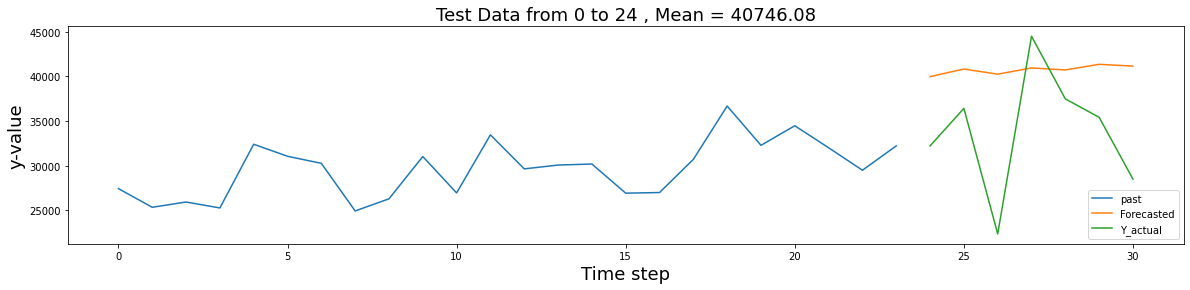

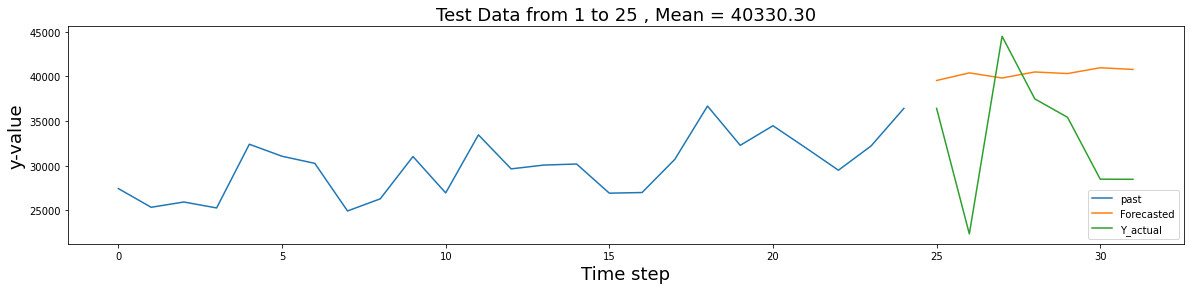

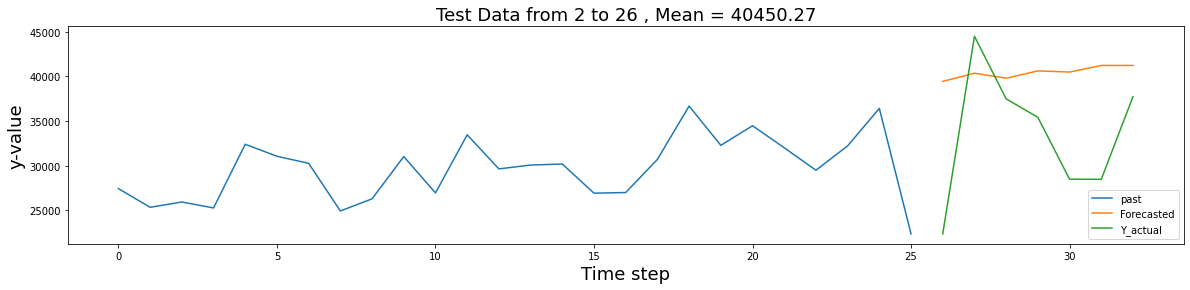

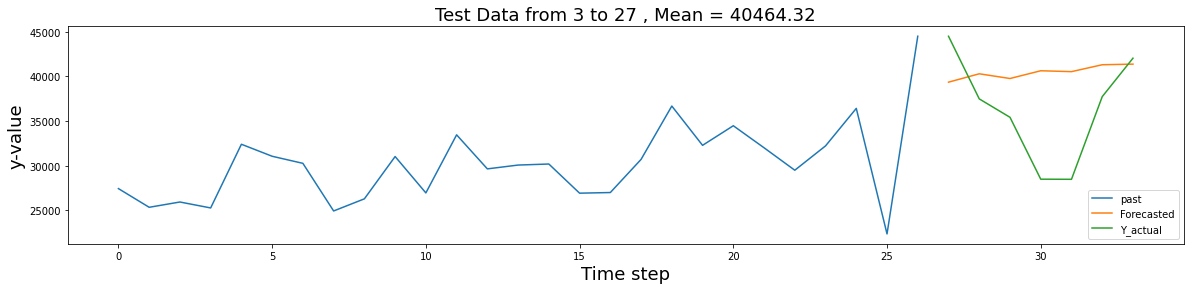

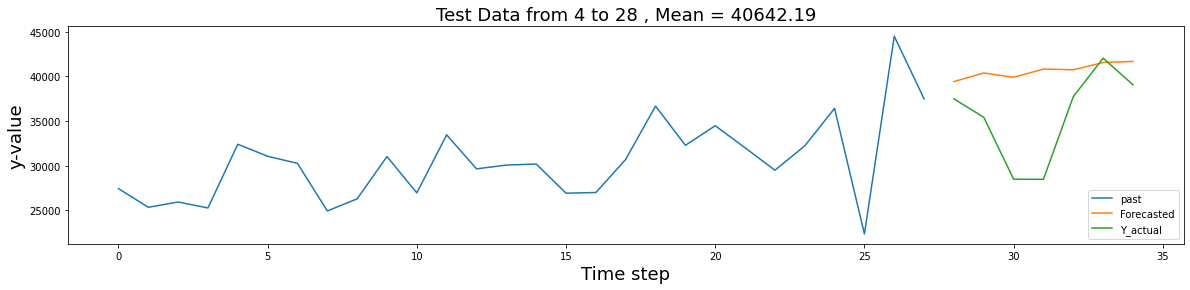

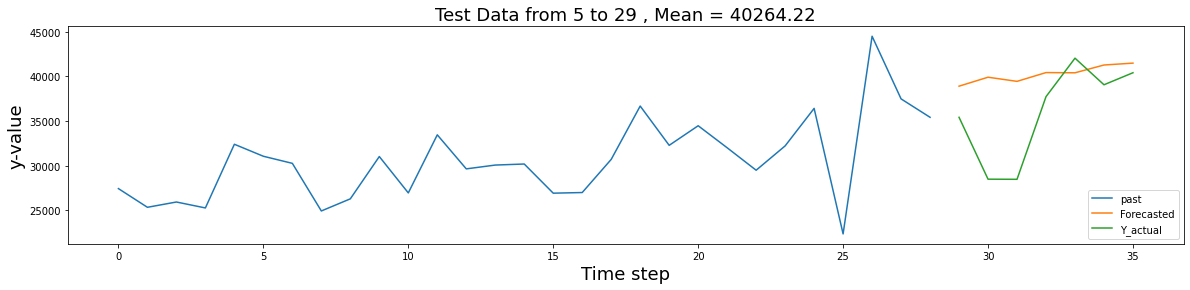

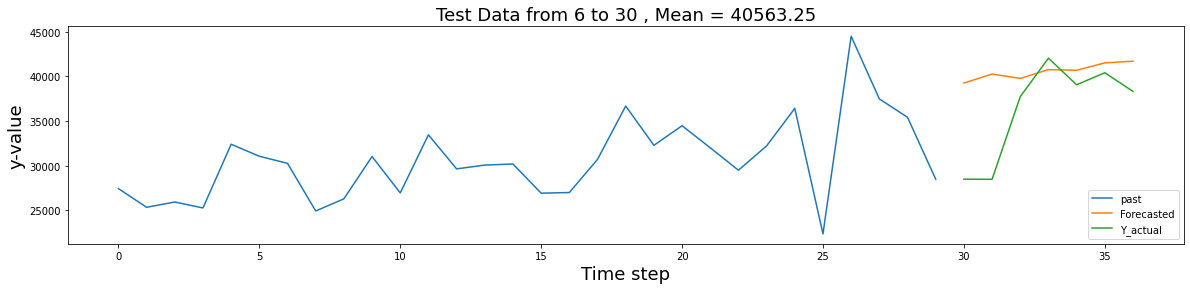

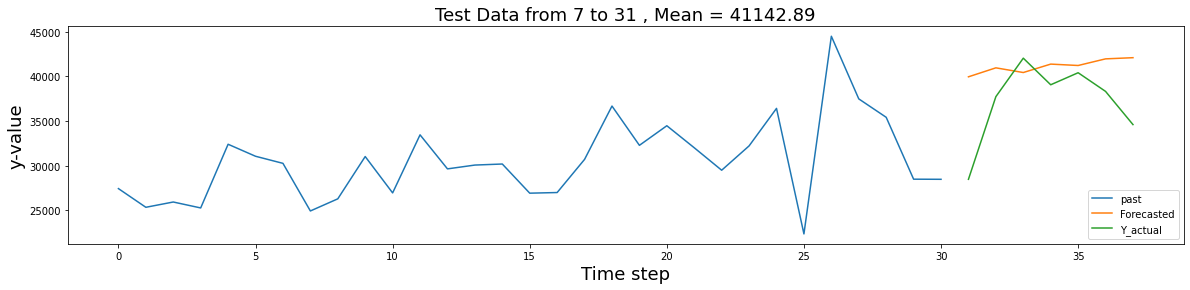

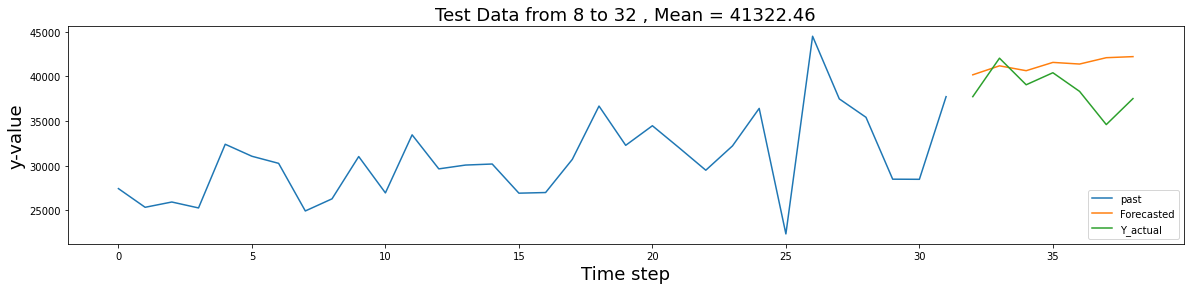

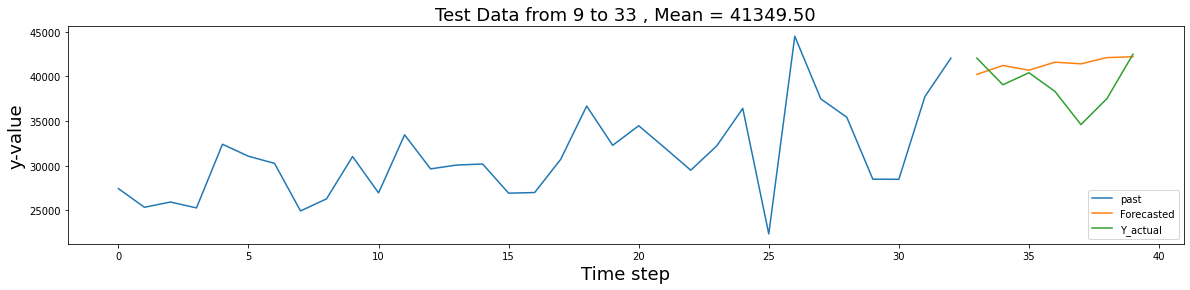

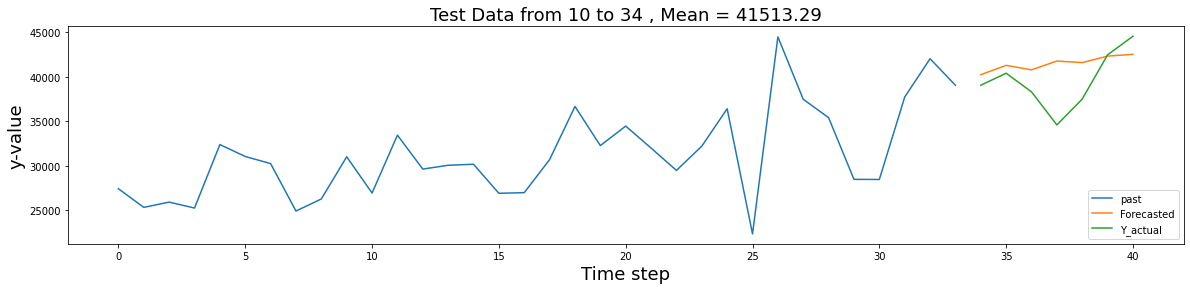

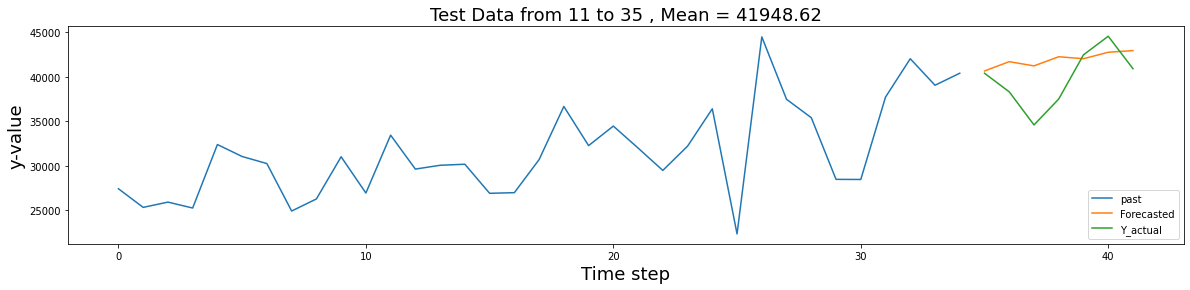

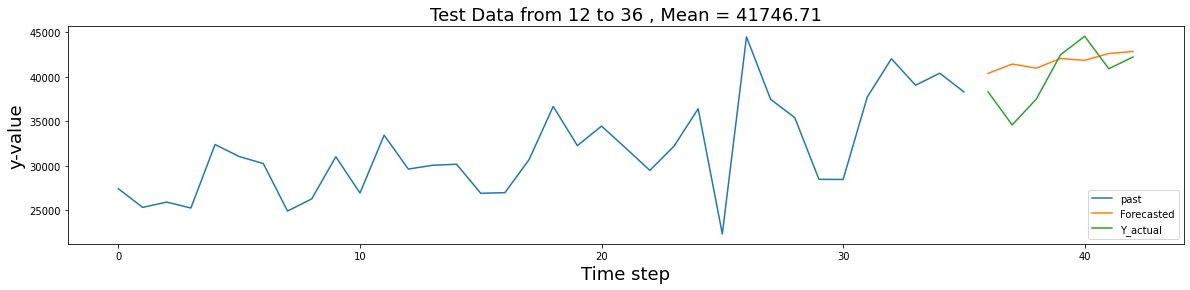

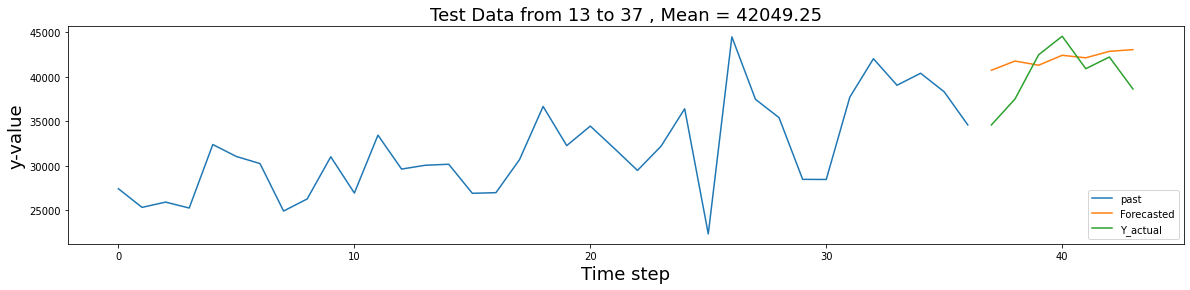

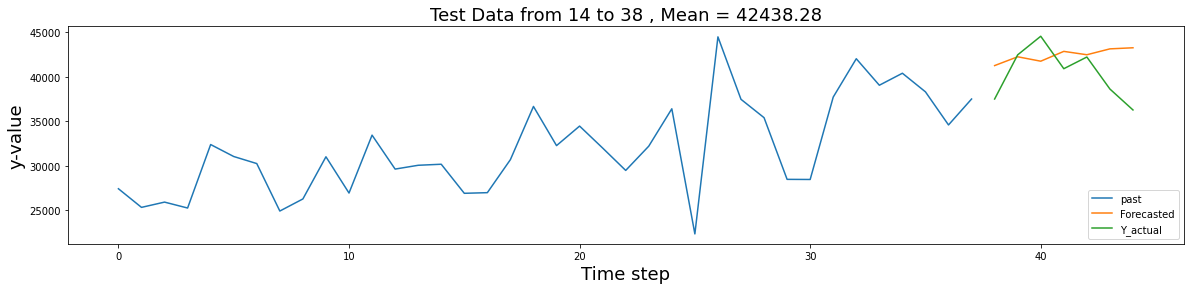

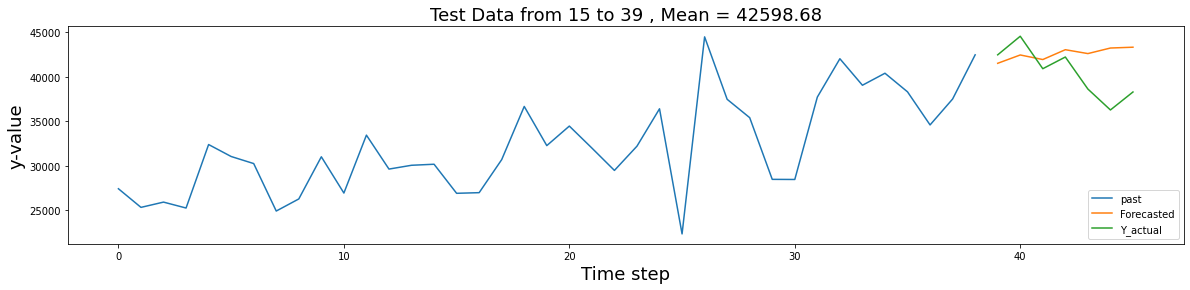

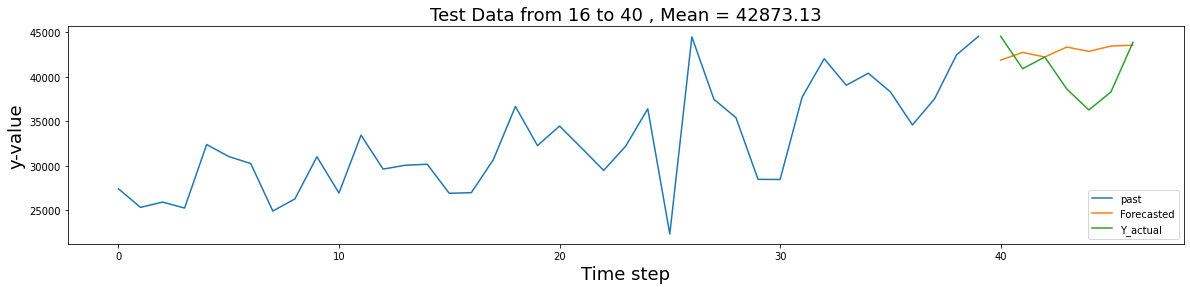

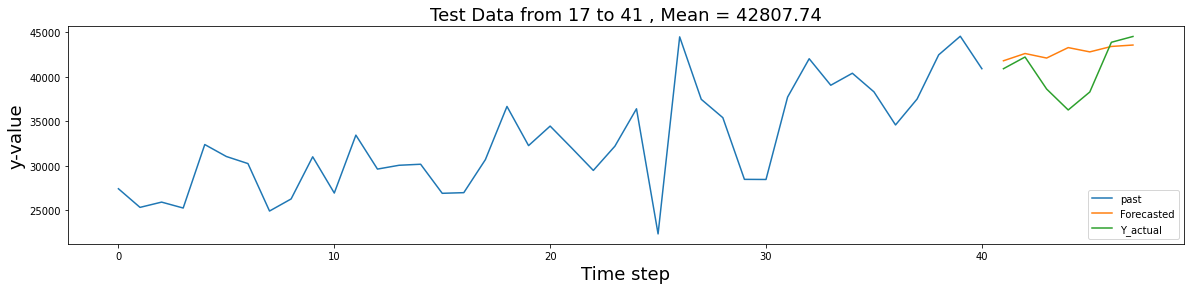

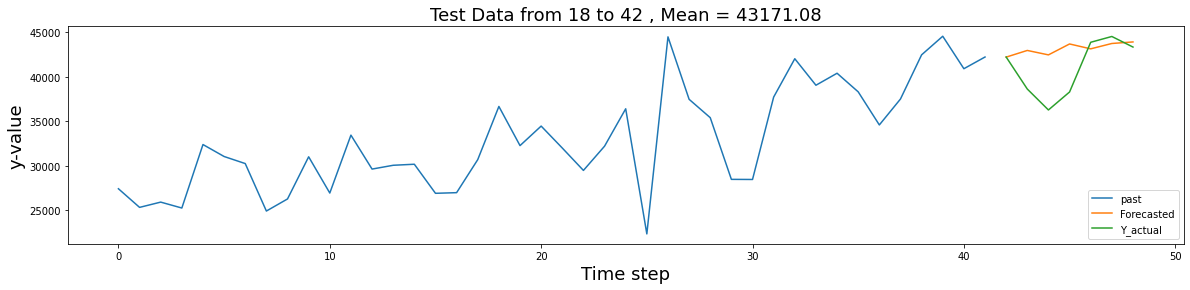

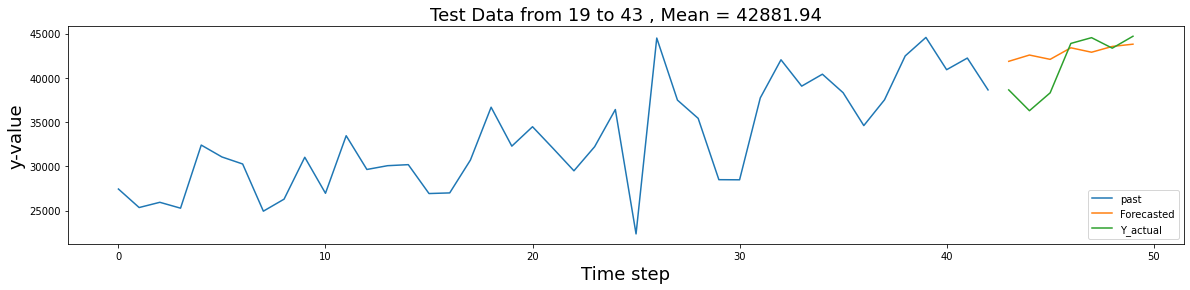

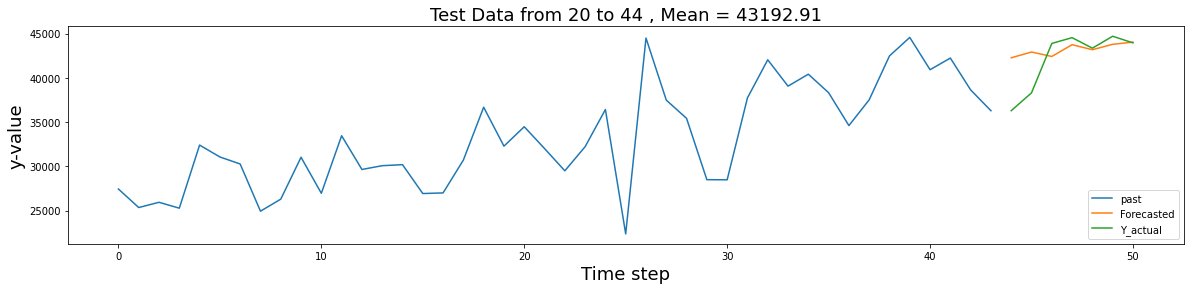

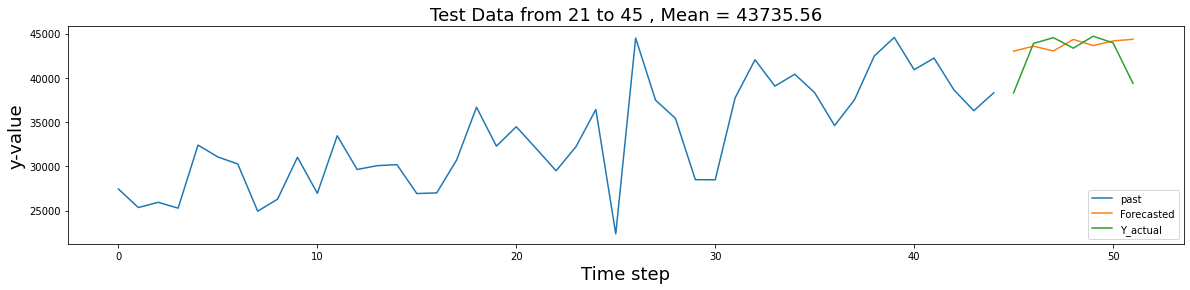

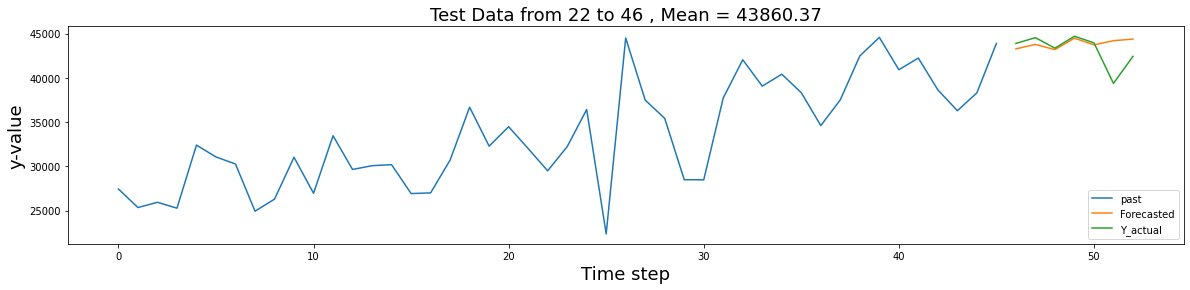

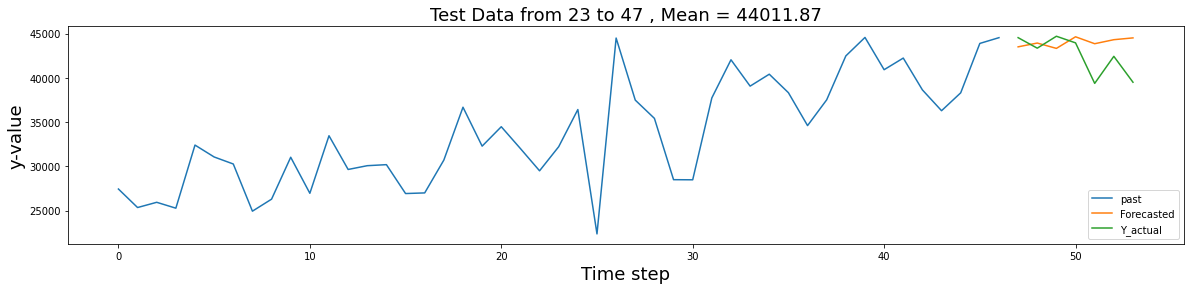

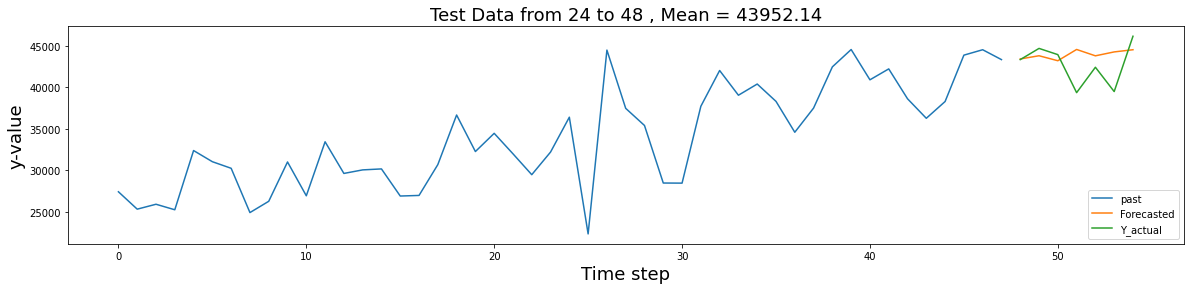

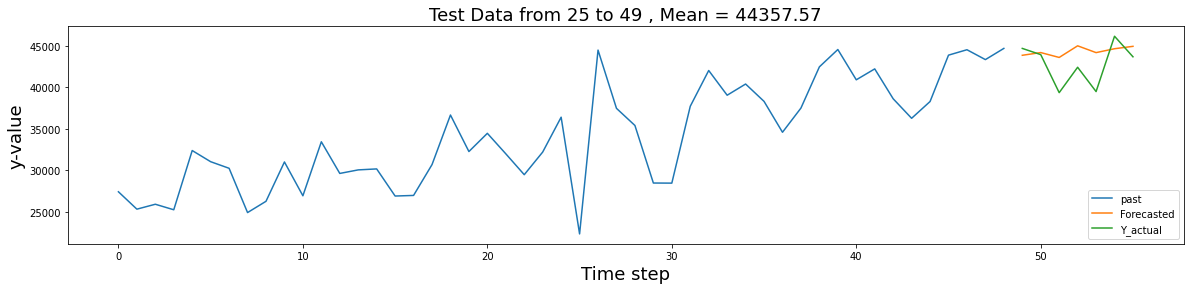

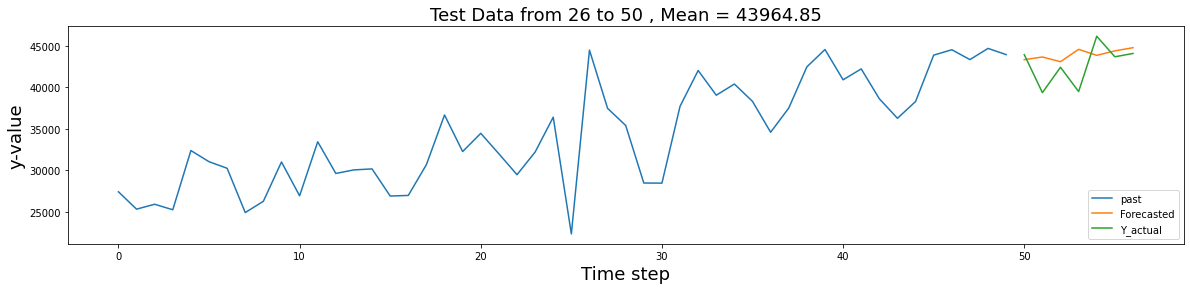

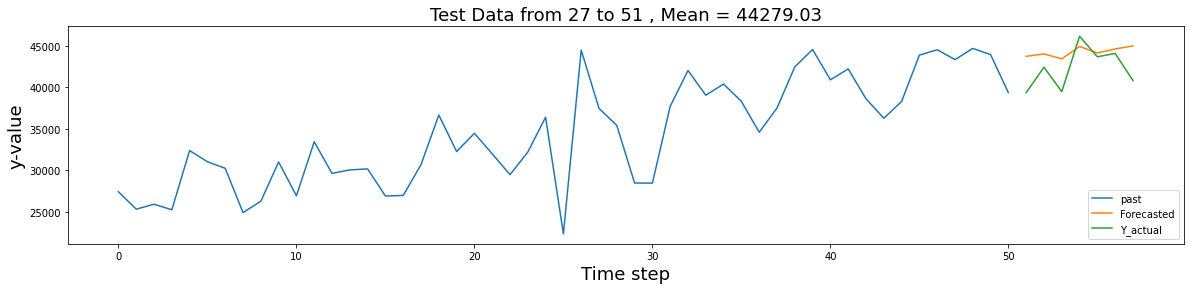

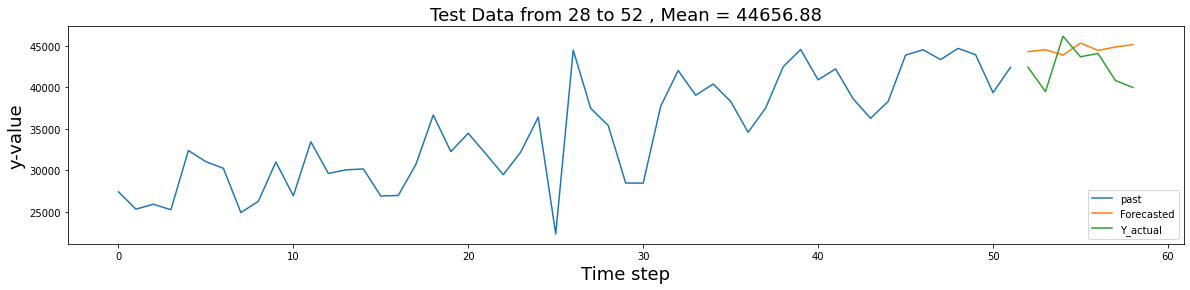

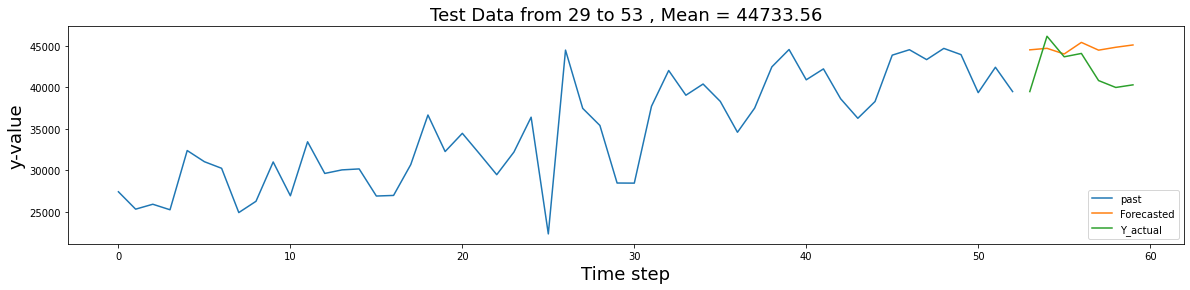

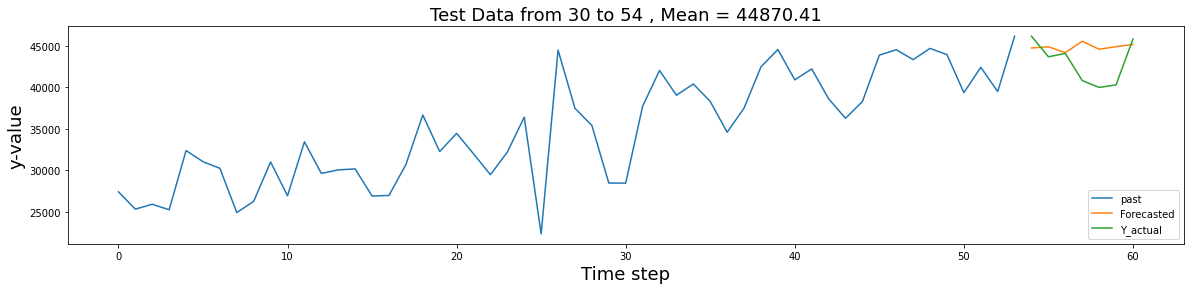

In [27]:
for i in range(0,31,1):
    start = i
    end = start + n_steps_in 
    last = end + n_steps_out 
    pred7, real7, past24 = prep_data(Y_test_lstm, Y_test_pred_multi_lstm, start, end, last) 
    evaluate_prediction(pred7, real7 , start , end) 
    plot_multistep(past24 , pred7 , real7 , start , end) 

# GRU

In [28]:
# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
batch_size = 32
n_steps_in = 24
n_steps_out = 7
epoch = 40
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_con = scaler_X_tr.fit_transform(X_train[continous_feature])
X_train_cat = X_train[category_feature].to_numpy()
X_train_gru = np.concatenate((X_train_con, X_train_cat), axis=1)
Y_train_gru = scaler_Y_tr.fit_transform(Y_train)

X_test_con = scaler_X_tr.transform(X_test[continous_feature])
X_test_cat = X_test[category_feature].to_numpy()
X_test_gru = np.concatenate((X_test_con, X_test_cat), axis=1)
Y_test_gru = scaler_Y_tr.transform(Y_test)


In [29]:
print('X_train_gru:', X_train_gru.shape, 'Y_train_gru:', Y_train_gru.shape)
print('X_test_gru:', X_test_gru.shape, 'Y_test_gru:', Y_test_gru.shape)

X_train_gru: (1021, 54) Y_train_gru: (1021, 1)
X_test_gru: (60, 54) Y_test_gru: (60, 1)


In [30]:
## X / Y Split
X_train_multi_gru, Y_train_multi_gru = [], []
for index in range(len(X_train_gru)):
    # find the end of this pattern
    end_ix = index + n_steps_in
    out_end_ix = end_ix + n_steps_out - 1
    # check if we are beyond the dataset
    if out_end_ix > len(X_train_gru):
        break
    #gather input and output parts of the pattern
    seq_x, seq_y = X_train_gru[index:end_ix, :], Y_train_gru[end_ix-1:out_end_ix, -1]
    X_train_multi_gru.append(seq_x)
    Y_train_multi_gru.append(seq_y)
X_train_multi_gru, Y_train_multi_gru = np.array(X_train_multi_gru), np.array(Y_train_multi_gru) 
print('X_train_multi_gru:', X_train_multi_gru.shape, 'Y_train_multi_gru:', Y_train_multi_gru.shape)


X_test_multi_gru, Y_test_multi_gru = [], []
for index in range(len(X_test_gru)):
    # find the end of this pattern
    end_ix = index + n_steps_in
    out_end_ix = end_ix + n_steps_out - 1
    # check if we are beyond the dataset
    if out_end_ix > len(X_test_gru):
        break
    #gather input and output parts of the pattern
    seq_x, seq_y = X_test_gru[index:end_ix, :], Y_test_gru[end_ix-1:out_end_ix, -1]
    X_test_multi_gru.append(seq_x)
    Y_test_multi_gru.append(seq_y)
X_test_multi_gru, Y_test_multi_gru = np.array(X_test_multi_gru), np.array(Y_test_multi_gru) 
print('X_test_multi_gru:', X_test_multi_gru.shape, 'Y_test_multi_gru:', Y_test_multi_gru.shape)

X_train_multi_gru: (992, 24, 54) Y_train_multi_gru: (992, 7)
X_test_multi_gru: (31, 24, 54) Y_test_multi_gru: (31, 7)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 24, 128)           70656     
                                                                 
 dropout_4 (Dropout)         (None, 24, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 24, 256)           296448    
                                                                 
 dropout_5 (Dropout)         (None, 24, 256)           0         
                                                                 
 gru_2 (GRU)                 (None, 24, 128)           148224    
                                                                 
 dropout_6 (Dropout)         (None, 24, 128)           0         
                                                                 
 gru_3 (GRU)                 (None, 64)               

2022-06-08 14:37:08.425148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 118s 4s/step - loss: 0.0761
Epoch 2/40
31/31 [==============================] - 115s 4s/step - loss: 0.0119
Epoch 3/40
31/31 [==============================] - 114s 4s/step - loss: 0.0097
Epoch 4/40
31/31 [==============================] - 112s 4s/step - loss: 0.0089
Epoch 5/40
31/31 [==============================] - 86s 3s/step - loss: 0.0092
Epoch 6/40
31/31 [==============================] - 75s 2s/step - loss: 0.0085
Epoch 7/40
31/31 [==============================] - 76s 2s/step - loss: 0.0077
Epoch 8/40
31/31 [==============================] - 77s 2s/step - loss: 0.0075
Epoch 9/40
31/31 [==============================] - 77s 2s/step - loss: 0.0073
Epoch 10/40
31/31 [==============================] - 77s 2s/step - loss: 0.0074
Epoch 11/40
31/31 [==============================] - 76s 2s/step - loss: 0.0069
Epoch 12/40
31/31 [==============================] - 77s 2s/step - loss: 0.0065
Epoch 13/40
31/31 [==============================] - 77s

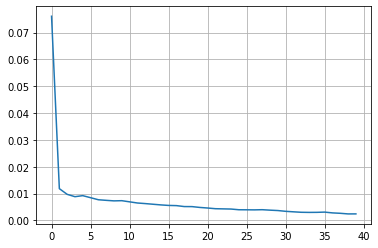

2022-06-08 15:30:41.021556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-08 15:30:51.334917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [31]:
# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train_multi_gru.shape[1], X_train_multi_gru.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit_multi_gru = model.fit(X_train_multi_gru, Y_train_multi_gru, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit_multi_gru.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred_multi_gru = model.predict(X_train_multi_gru)
Y_test_pred_multi_gru = model.predict(X_test_multi_gru)

In [32]:
if scaler_Y_tr != []:
    Y_train_multi_gru = scaler_Y_tr.inverse_transform(Y_train_multi_gru)
    Y_train_pred_multi_gru = scaler_Y_tr.inverse_transform(Y_train_pred_multi_gru)
    Y_test_multi_gru = scaler_Y_tr.inverse_transform(Y_test_multi_gru)
    Y_test_pred_multi_gru = scaler_Y_tr.inverse_transform(Y_test_pred_multi_gru)

Test Data from 0 to 24
Mean Absolute Error: 8466.28
Mean Absolute Percenatge Error: 29.51


Test Data from 1 to 25
Mean Absolute Error: 8830.06
Mean Absolute Percenatge Error: 31.05


Test Data from 2 to 26
Mean Absolute Error: 8115.76
Mean Absolute Percenatge Error: 28.74


Test Data from 3 to 27
Mean Absolute Error: 5741.41
Mean Absolute Percenatge Error: 17.61


Test Data from 4 to 28
Mean Absolute Error: 5239.20
Mean Absolute Percenatge Error: 16.64


Test Data from 5 to 29
Mean Absolute Error: 4750.22
Mean Absolute Percenatge Error: 15.22


Test Data from 6 to 30
Mean Absolute Error: 4395.03
Mean Absolute Percenatge Error: 13.90


Test Data from 7 to 31
Mean Absolute Error: 4039.10
Mean Absolute Percenatge Error: 12.02


Test Data from 8 to 32
Mean Absolute Error: 2661.44
Mean Absolute Percenatge Error: 7.11


Test Data from 9 to 33
Mean Absolute Error: 2766.89
Mean Absolute Percenatge Error: 7.48


Test Data from 10 to 34
Mean Absolute Error: 3165.94
Mean Absolute Percenatge Erro

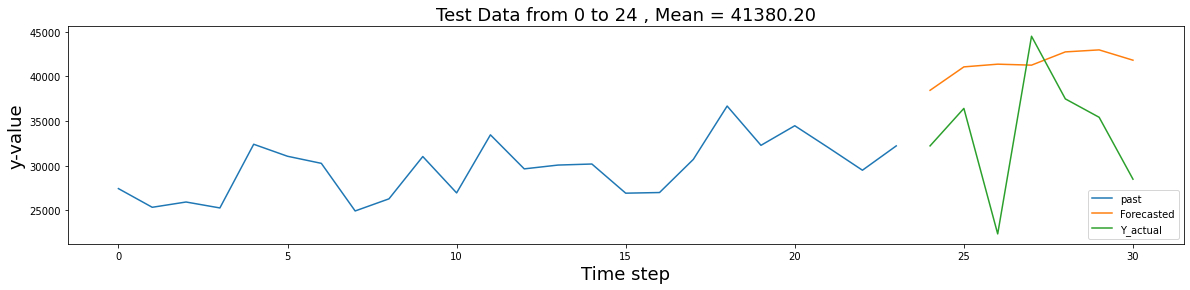

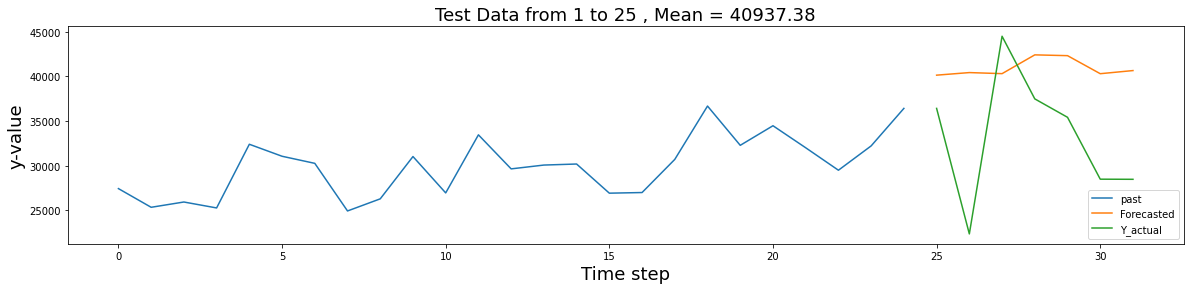

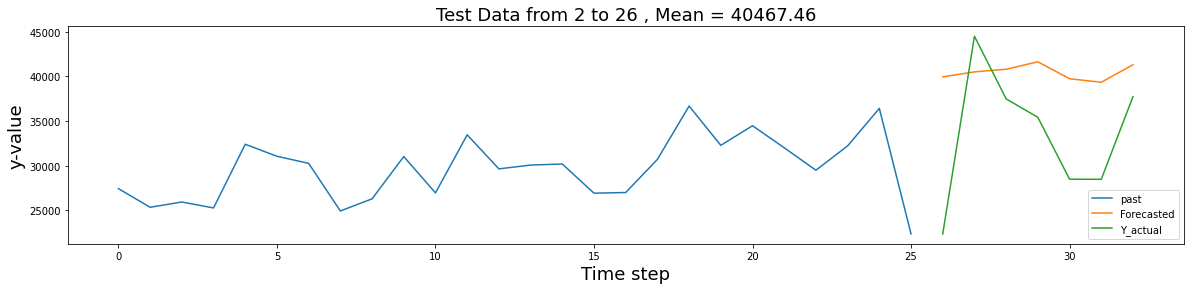

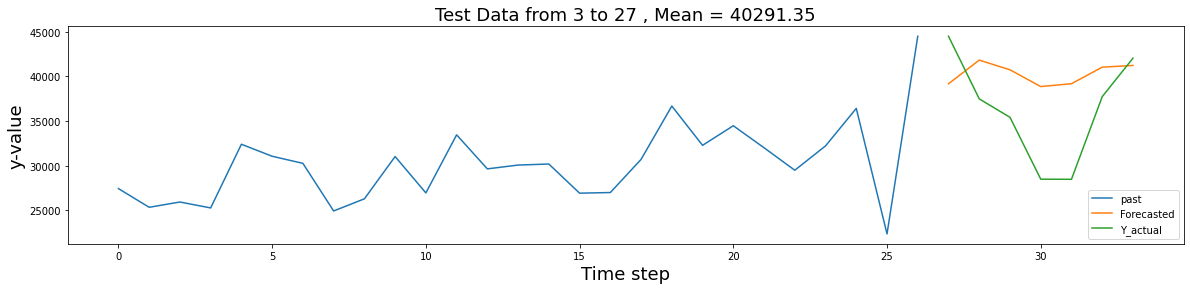

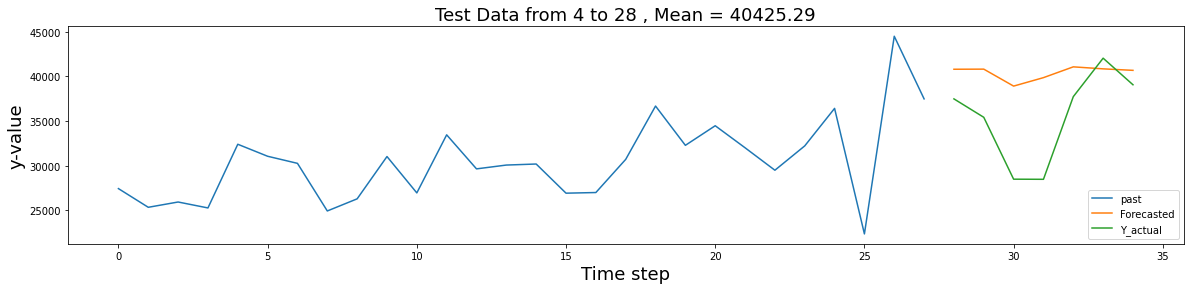

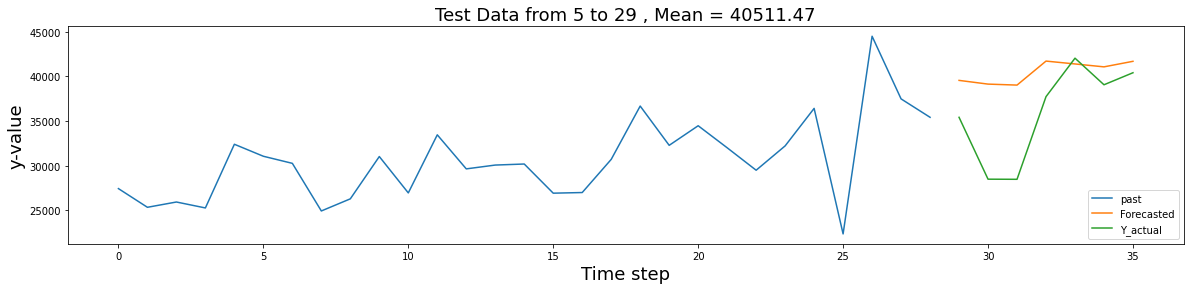

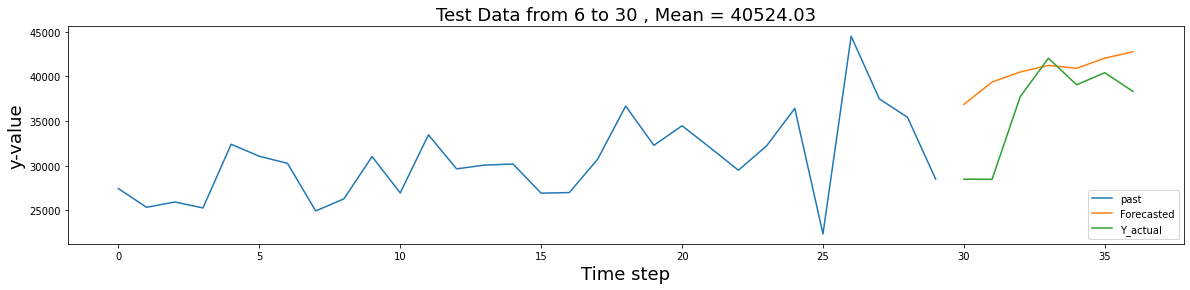

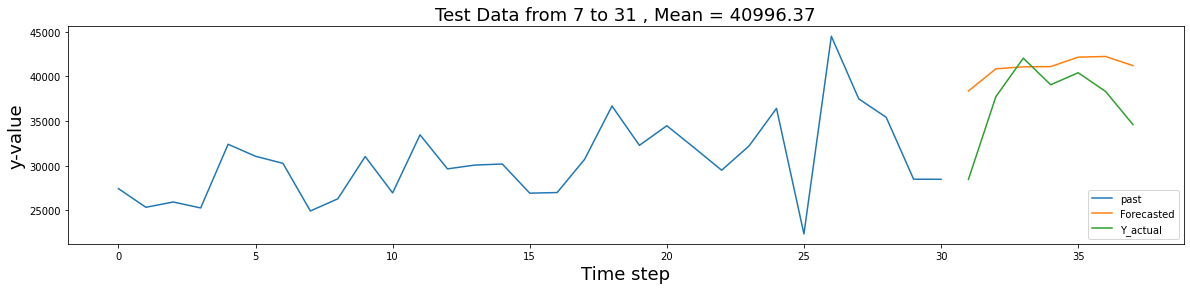

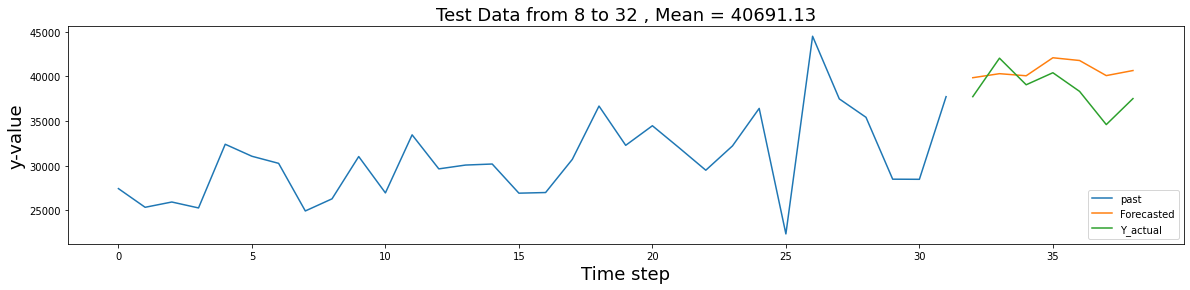

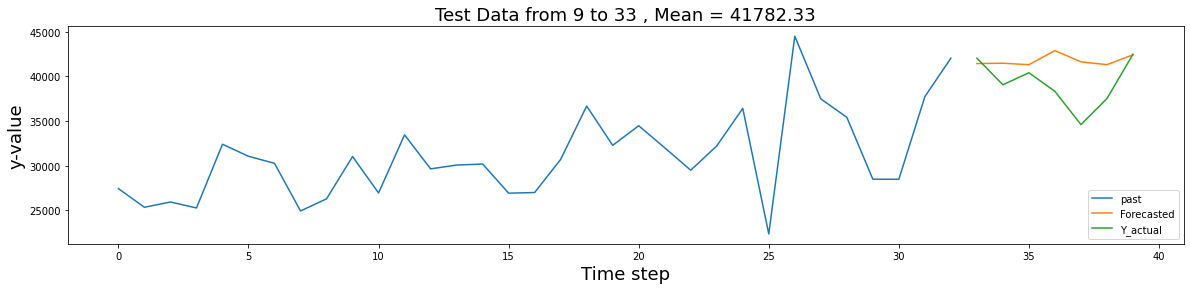

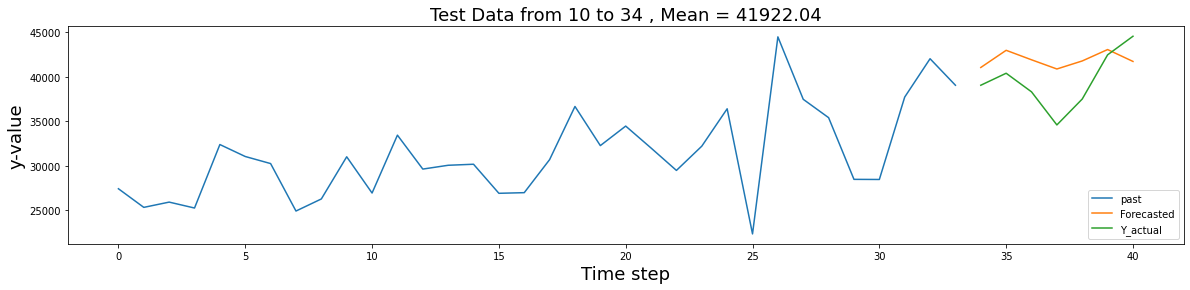

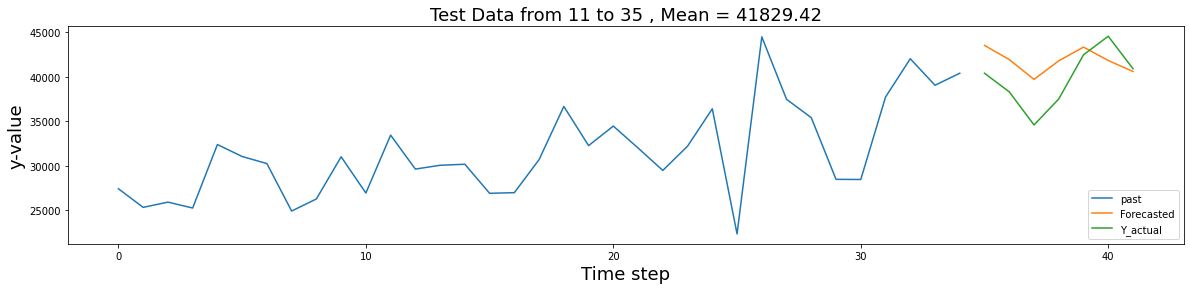

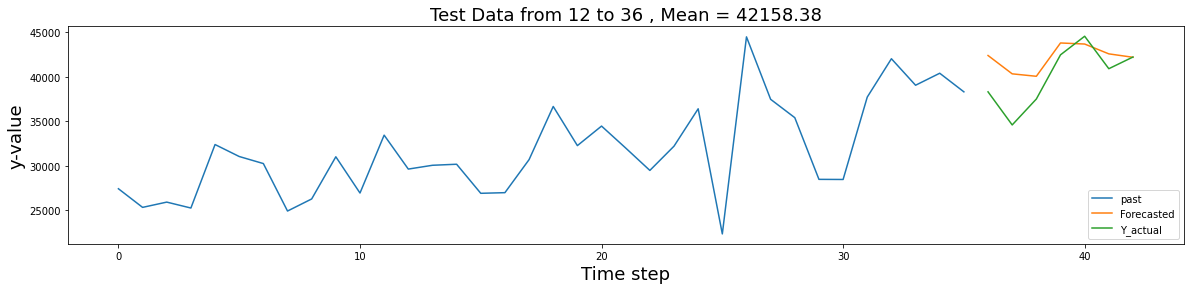

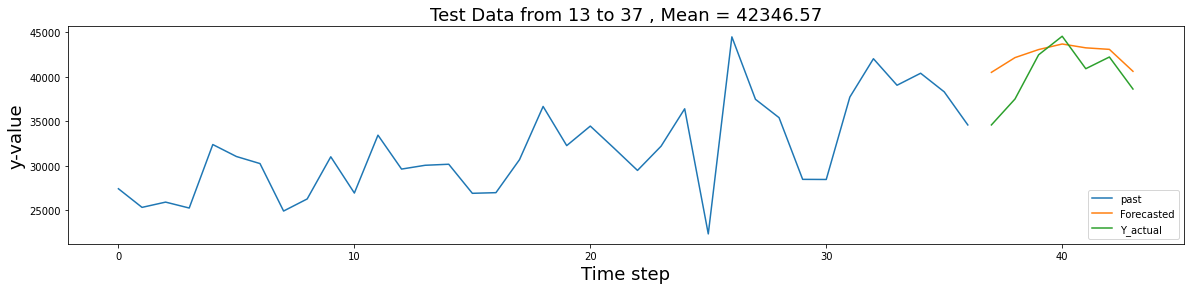

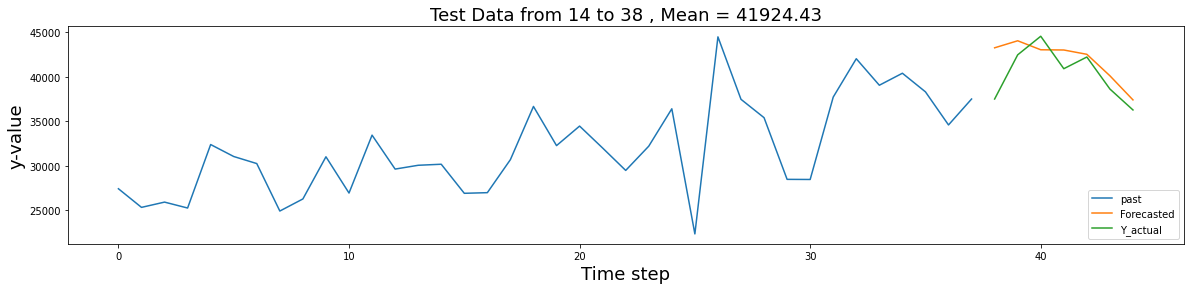

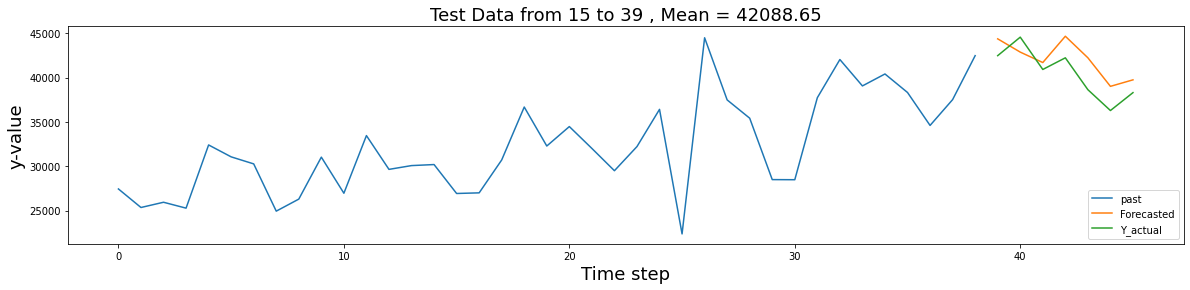

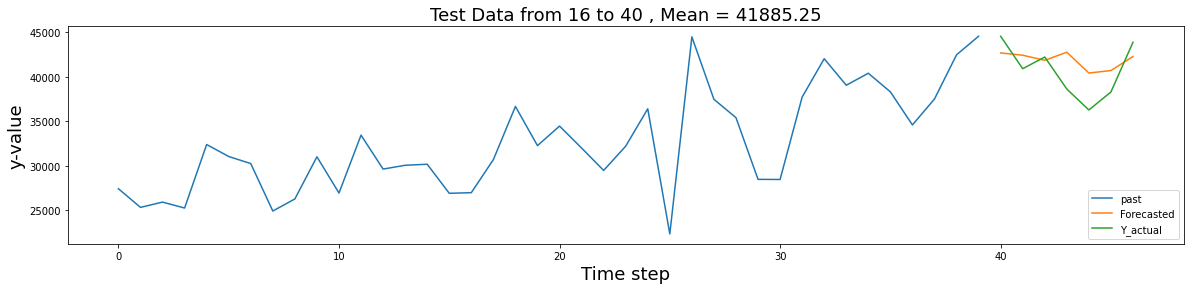

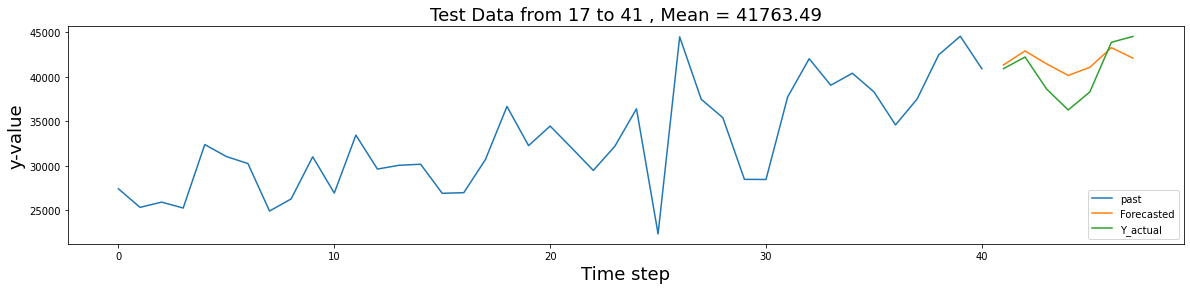

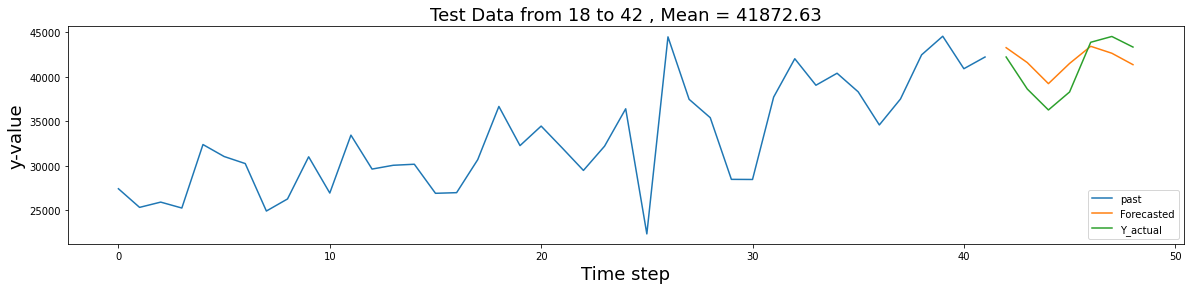

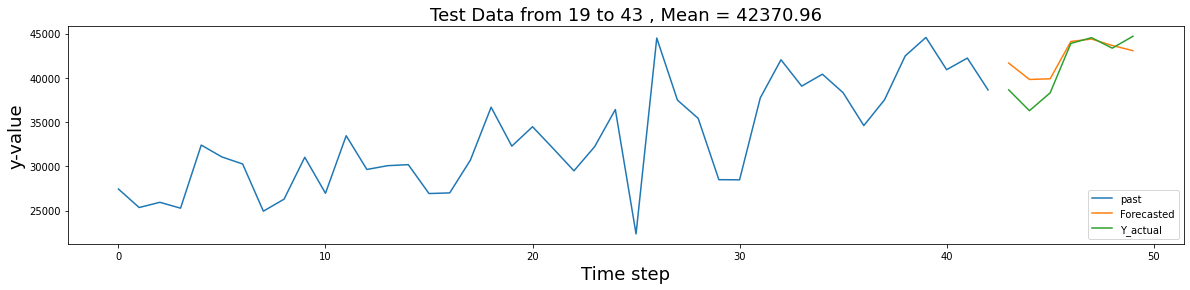

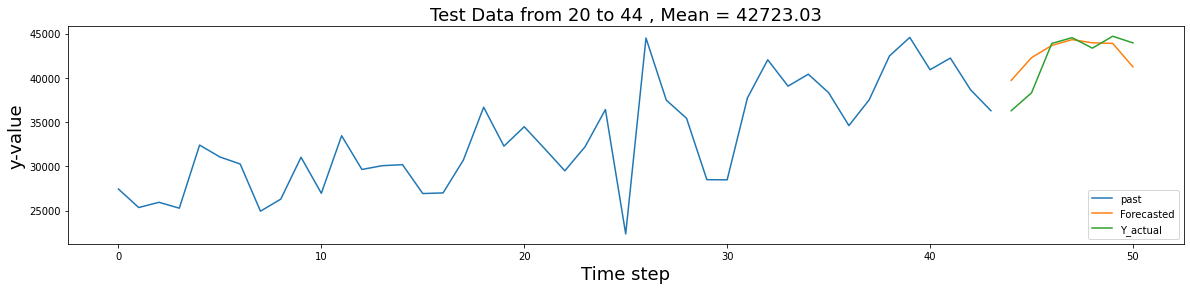

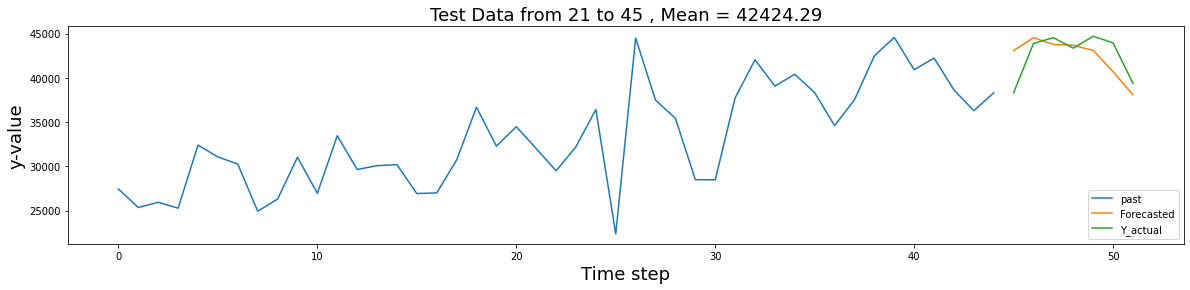

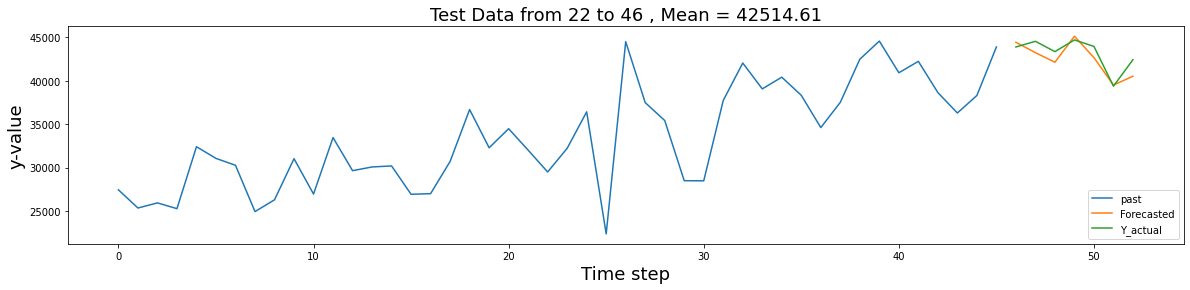

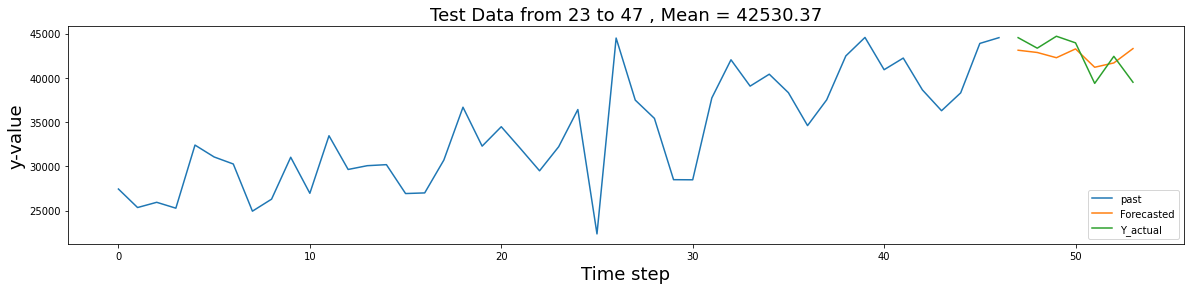

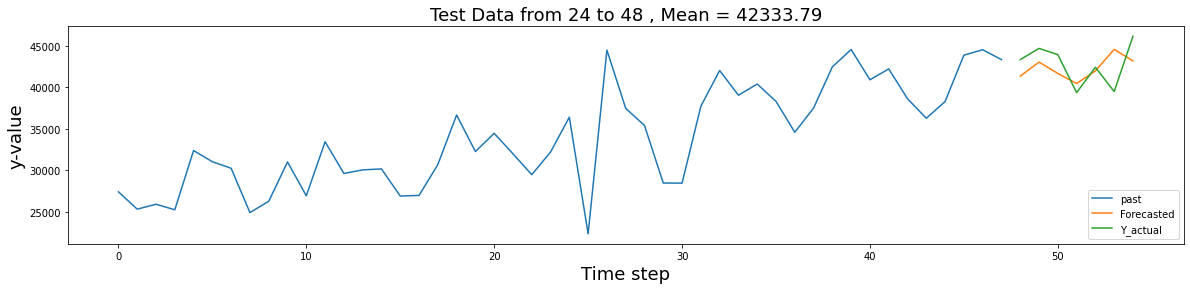

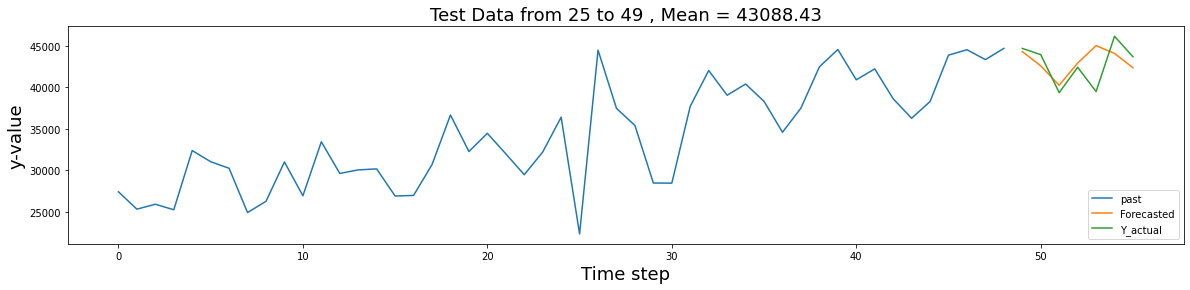

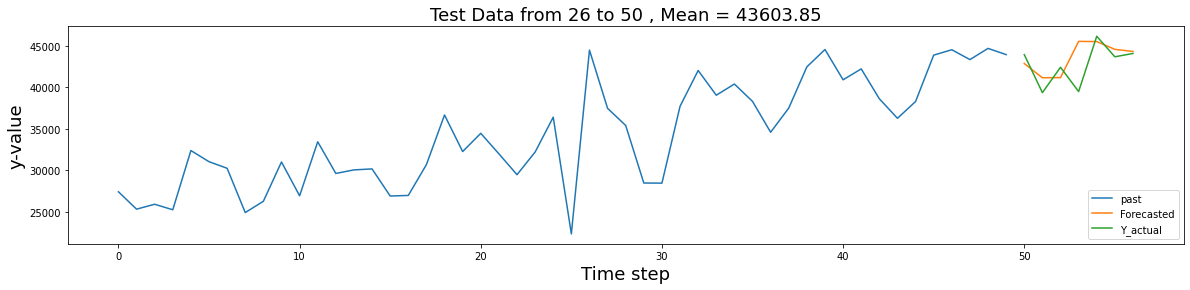

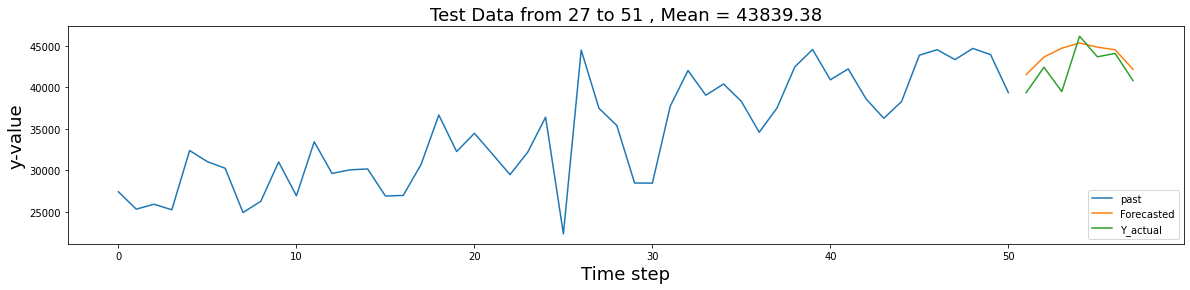

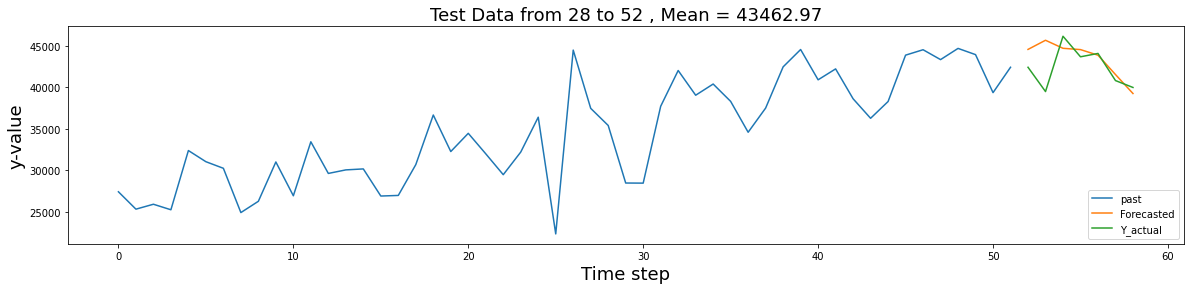

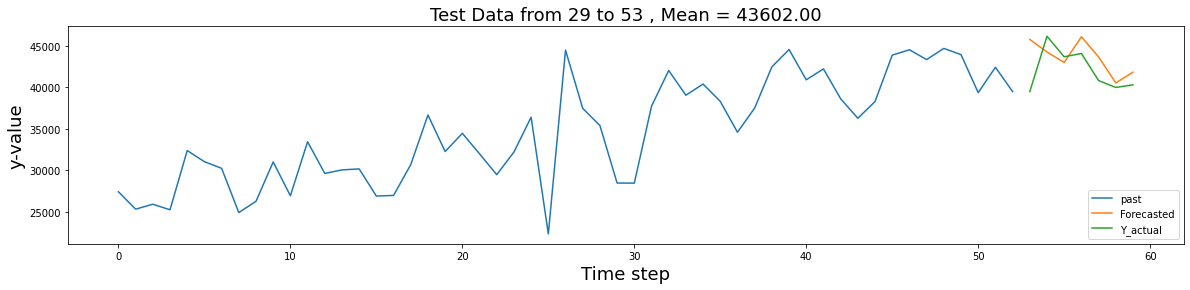

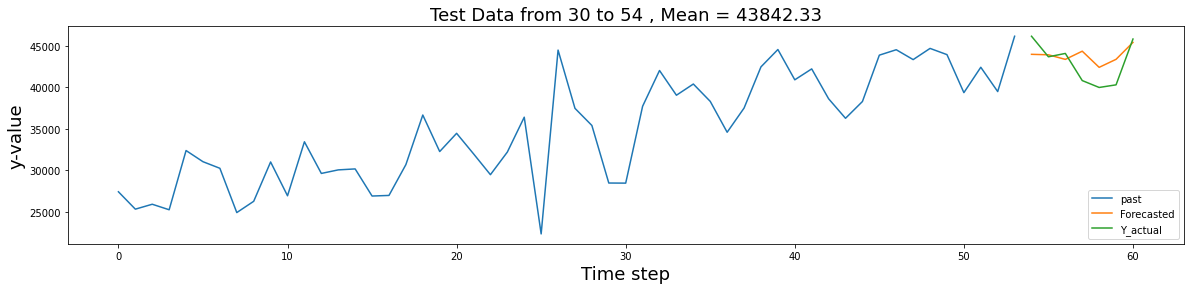

In [33]:
for i in range(0,31,1):
    start = i
    end = start + n_steps_in 
    last = end + n_steps_out 
    pred7, real7, past24 = prep_data(Y_test_gru, Y_test_pred_multi_gru, start, end, last) 
    evaluate_prediction(pred7, real7 , start , end) 
    plot_multistep(past24 , pred7 , real7 , start , end) 

In [34]:
#Y_test.to_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/gru_y_check/Y_test.csv')
#pd.DataFrame(scaler_Y_tr.inverse_transform(Y_test_gru)).to_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/gru_y_check/Y_test_gru.csv')
#pd.DataFrame(Y_test_pred_multi_gru).to_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/gru_y_check/Y_test_pred_multi_gru.csv')